In [1]:
##IMPORTACION DE LIBRERIAS
import os
import numpy as np
import sklearn
import glob
import imutils
import dlib
import cv2
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors.nca import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier

## CLASE PARA REUTILIZAR EL CODIGO MAS FACILMENTE

class clase_auxiliar:
    ## this class is programmed to the path_to_photos variable contains another carpets
    ## where the files names are the labels of the images inside them
    ##
    ##no class attribute by now
    ##
    def __init__(self,shape_predictor_path,face_rec_model_path):
        
        self.shape_predictor_path=shape_predictor_path
        self.face_rec_model_path=face_rec_model_path
        self.detector = dlib.get_frontal_face_detector()
        self.sp = dlib.shape_predictor(self.shape_predictor_path)
        self.facerec = dlib.face_recognition_model_v1(self.face_rec_model_path)
        self.knn_model=None
        self.nca_component=None
        
        
    def obteniendo_parametros(self,path_to_photos,show=False):
        # 
        #getting parameters from many photos
        #the variable path_to_photos points to a file that contains files with the names
        #that contains many photos of that person of the name carpet
        #
        
        if show is True:
            win = dlib.image_window()
            
        final_array_embeddings=[]
        final_array_label=[]

        for ft1 in glob.glob(os.path.join(path_to_photos, "*")):
            
            temp_array_label=[]
            temp_array_embeddings=[]
            
            for ft2 in glob.glob(os.path.join(ft1,"*.jpg")):
                print("Processing file: {}".format(ft2.rsplit('/')[-2]+"/"+ft2.rsplit('/')[-1]))
                
                image = dlib.load_rgb_image(ft2)
                image = imutils.resize(image, width=600)
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                print(image.shape)
                dets = self.detector(gray, 1)
                
                if show is True:
                    win.clear_overlay()
                    win.set_image(image)
                
                print("Number of faces detected:{}".format(len(dets)))
                
                for k,d in enumerate(dets):
                    
                    shape=self.sp(image,d)
                    
                    if show is True:
                        win.add_overlay(d)
                        win.add_overlay(shape)

                    face_chip = dlib.get_face_chip(image, shape)        

                    face_descriptor_from_prealigned_image = self.facerec.compute_face_descriptor(face_chip)
                    temp_array_embeddings.append(face_descriptor_from_prealigned_image)
                    temp_array_label.append(ft1.rpartition('/')[-1])

            final_array_label.extend(temp_array_label)
            final_array_embeddings.extend(temp_array_embeddings)
        
        final_array_label_np = np.array(final_array_label)
        final_array_embeddings_np =np.array(final_array_embeddings)
        
        return final_array_embeddings_np,final_array_label_np
    
        ##
        ##return first , the 128 vector , and after the respective labels
        ## these vector allows us to train our models
        ##
    
    def obteniendo_parametro(self,path_to_photo):
        #
        #return the embedding of just a one photo
        #
        #win = dlib.image_window()
        
        temp_array_label=[]
        temp_array_embeddings=[]
        img = dlib.load_rgb_image(path_to_photo)
        gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                
        dets = self.detector(img, 1)
        #win.clear_overlay()
        #win.set_image(img)

        for k,d in enumerate(dets):
            shape = self.sp(img, d)
            #win.clear_overlay()
            #win.add_overlay(d)
            #win.add_overlay(shape)

            face_chip = dlib.get_face_chip(img, shape)        

            face_descriptor_from_prealigned_image = self.facerec.compute_face_descriptor(face_chip)
            temp_array_embeddings.append(face_descriptor_from_prealigned_image)
            temp_array_label.append(path_to_photo.rpartition('/')[-1])
        
        return np.array(temp_array_embeddings),np.array(temp_array_label)
        
    
    def getting_predictions(self,path_to_test):
        #
        #muestra las fotos con sus recuadros y etiquetas
        #previamente haber entrenado el modelo en el objeto o asignarle un objeto externo
        #
        #
        
        for ft2 in glob.glob(os.path.join(path_to_test,"*.jpg")):
            
            print("Processing file: {}".format(ft2.rsplit('/')[-2]+"/"+ft2.rsplit('/')[-1]))
            #image=dlib.load_rgb_image(ft2)
            image = cv2.imread(ft2)
            ##BGR from imread
            image = imutils.resize(image, width=600)
            
            if len(image.shape):
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            rects = self.detector(gray, 1)
            
            print("Number of faces detected:{}".format(len(rects)))
            
            # loop over the face detections
            for (i, rect) in enumerate(rects):
                
                (x, y, w, h) = self.__rect_to_bb(rect)
                shape = self.sp(gray, rect)
                face_chip = dlib.get_face_chip(image, shape)        
                face_descriptor_from_prealigned_image = self.facerec.compute_face_descriptor(face_chip)
                #face_descriptor_from_prealigned_image = np.array(face_descriptor_from_prealigned_image).reshape(1,-1)
                if self.nca_component is not None:
                    embeddings = self.nca_component.transform(np.array(face_descriptor_from_prealigned_image).reshape(1,-1))
                else :
                    embeddings = np.array(face_descriptor_from_prealigned_image).reshape(1,-1)
                
                ### HERE, we are knowing the confidence rating for asigning a good label
                confidence_rate = self.knn_model.predict_proba(embeddings)
                confidence_rate= np.amax(confidence_rate[0])*100
                
                label='unknown'
                if(confidence_rate>=55):
                    predicted_label=self.knn_model.predict(embeddings)
                    label=str(predicted_label[0])

                cv2.rectangle(image, (x, y),(x + w, y + h), (0, 255, 0), 3)
                startX = x
                startY = y - 15 if y - 15 > 15 else y + 15
                cv2.putText(image, label + ' '+str(confidence_rate)+'%', (startX, startY),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                print(label)
            cv2.imshow("Image", image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        cv2.destroyAllWindows()
        
        return
    
    def knn_train(self,X_data,y_labels,nca=False):
        #
        #return the object containing the trained model
        #

        knn_model_test = KNeighborsClassifier(n_neighbors=4)
        
        if nca is True:
            nca = NeighborhoodComponentsAnalysis(random_state=42)
            nca.fit(X_data, y_labels)
            self.nca_component=nca
            knn_model_test.fit(nca.transform(X_data),y_labels)
        else:
            knn_model_test.fit(X_data,y_labels)
        
        self.knn_model=knn_model_test
        
        return knn_model_test
    
    def get_prediction(self,input_embedding,predict_proba=False):
        #
        #returns the predicted label
        #
        
        if self.model_knn is not None:
            
            if predict_proba is True:
                if self.nca_component is None:
                    return self.model_knn.predict_proba(input_embedding.reshape(1,-1))
                else:
                    return self.model_knn.predict_proba(self.nca_component.transform(input_embedding).reshape(1,-1))
            else:    
                if self.nca_component is None:
                    return self.model_knn.predict(input_embedding.reshape(1,-1))
                else:
                    return self.model_knn.predict(self.nca_component.transform(input_embedding).reshape(1,-1))
                
        else:
            print("train the model")
            sys.exit('train the model')
            return
            
    
    def __rect_to_bb(self,rect):
        # take a bounding predicted by dlib and convert it
        # to the format (x, y, w, h) as we would normally do
        # with OpenCV
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y

        # return a tuple of (x, y, w, h)
        return (x, y, w, h)
    
    def video_prediction(self,video_path=None):
        
        if video_path is None:
            cap = cv2.VideoCapture(0)
            
        else : 
            cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
                print("can't open camera or video")
                sys.exit("can't open camera or video")
                
        while(True):

            # Capture frame-by-frame
            ret, frame = cap.read()

            frame = imutils.resize(frame, width=600)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #rects = cnn_detector(gray, 1)
            rects = self.detector(gray, 1)
            # Our operations on the frame come here
            for (i, rect) in enumerate(rects):

                (x, y, w, h) = self.__rect_to_bb(rect)
                shape = self.sp(frame, rect)
                face_chip = dlib.get_face_chip(frame, shape)
                
                face_descriptor_from_prealigned_image = self.facerec.compute_face_descriptor(face_chip)
                #face_descriptor_from_prealigned_image = np.array(face_descriptor_from_prealigned_image).reshape(1,-1)
                if self.nca_component is not None:
                    embeddings = self.nca_component.transform(np.array(face_descriptor_from_prealigned_image).reshape(1,-1)).reshape(1,-1)
                else :
                    embeddings = np.array(face_descriptor_from_prealigned_image).reshape(1,-1)
                
                ### HERE, we are knowing the confidence rating for asigning a good label
                confidence_rate = self.knn_model.predict_proba(embeddings)
                confidence_rate= np.amax(confidence_rate[0])*100
                
                label='unknown'
                if(confidence_rate>=55):
                    predicted_label=self.knn_model.predict(embeddings)
                    label=str(predicted_label[0])
                
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 1)
                startX = x
                startY = y - 15 if y - 15 > 15 else y + 15
                cv2.putText(frame, str(predicted_label[0]), (startX, startY),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 255), 2)
                
            # Display the resulting frame
            cv2.imshow('frame',frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # When everything done, release the capture
        cap.release()
        cv2.destroyAllWindows()

# ## PRESENTACION DEL DATASET

In [2]:
##SE DEFIENEN LOS DIRECTORIOS BASE
#path_root = os.path.join("FacialRecognition")
path_models = os.path.join("models")
path_images= os.path.join("images")

##DIRECTORIOS A LOS MODELOS
path_1 = os.path.join(path_models,"shape_predictor_68_face_landmarks.dat")
path_2 = os.path.join(path_models,"dlib_face_recognition_resnet_model_v1.dat")
path_3 = os.path.join(path_models,"mmod_human_face_detector.dat")

##DIRECTORIOS A LOS ARCHIVOS DE IMAGENES
path_3 = os.path.join(path_images,"5_images","train")
path_4 = os.path.join(path_images,"5_images","eval")
path_6 = os.path.join(path_images,"5_images","eval2")
path_7 = os.path.join(path_images,"5_images","new_train")
path_8 = os.path.join(path_images,"5_images","new_tests")

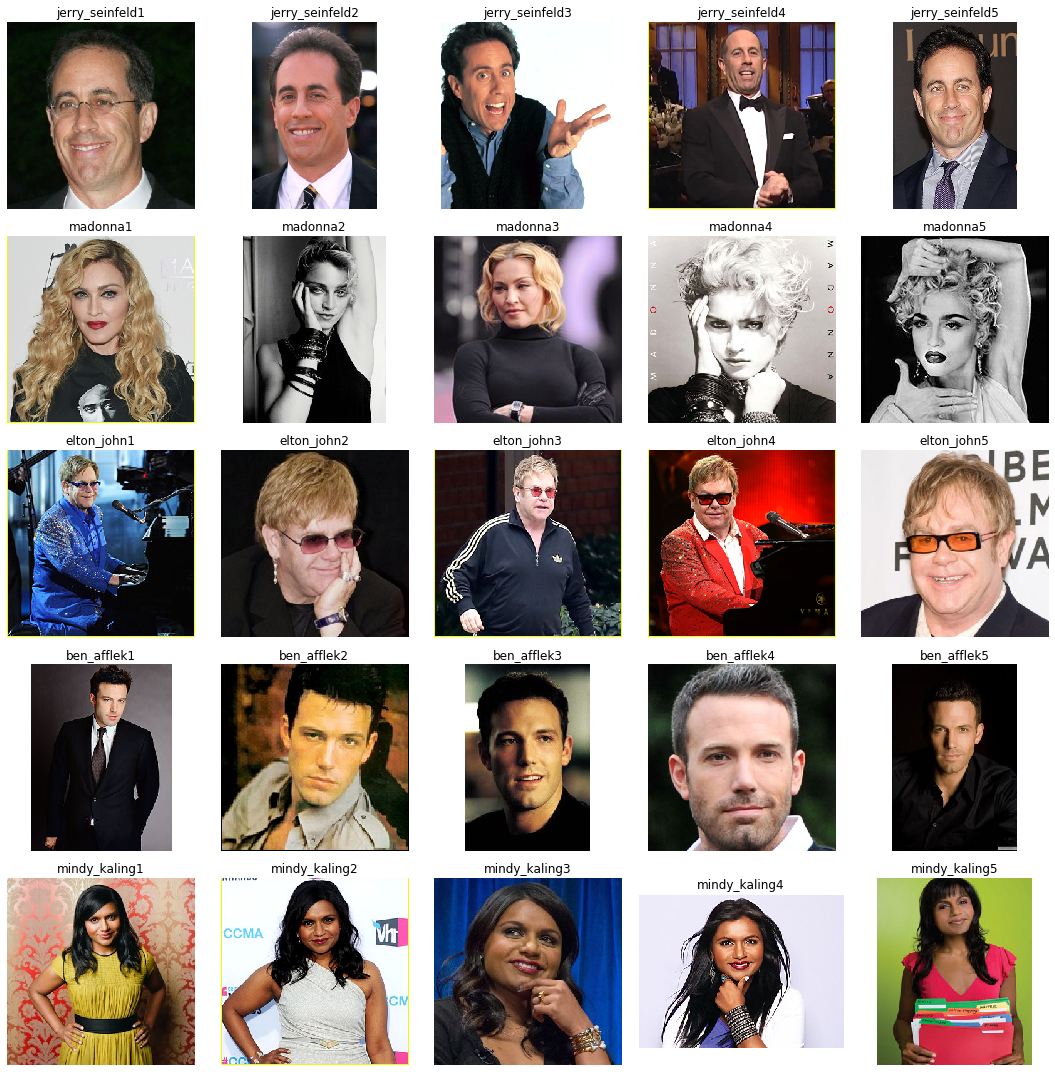

In [22]:
##VISTA DE FOTOS (DATA) DE ENTRENAMIENTO
dic={}
for ft1 in glob.glob(os.path.join(path_3, "*")):
    i=1
    for ft2 in glob.glob(os.path.join(ft1,"*.jpg")):
        dic[ft2.rsplit('/')[-2]+str(i)]=mpimg.imread(ft2,)
        i=i+1
        
def plot_figures(figures, nrows = 5, ncols=5):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=(15,15))
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray(),aspect='equal')
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
plot_figures(dic,5,5)

# TRATAMIENTO DE LA DATA

In [ ]:
## TRANSFORMACION DE LAS FOTOS A DATOS DE 128 ATRIBUTOS

In [ ]:
test_execution = clase_auxiliar(path_1,path_2)
X_data,y_labels = test_execution.obteniendo_parametros(path_3,show=False)

# SELECION Y PREPARACION DEL MODELO

In [ ]:
## ENTRENAMIENTO DEL MODELO PARA LA CLASIFCACION DE LAS FOTOS

In [ ]:
test_execution.knn_train(X_data,y_labels,nca=True)

In [ ]:
test_execution.getting_predictions(path_6)